In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import statsmodels.api as sm
import time
import optuna

In [ ]:
sp_df = pd.read_csv('/content/yahoo_stock.csv')

In [ ]:
sp_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [ ]:
sp_df.isna().sum()

,0
Date,0
High,0
Low,0
Open,0
Close,0
Volume,0
Adj Close,0


In [ ]:
sp_df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


In [ ]:
sp_df = sp_df[["Date","Close"]]

In [ ]:
sp_df.head()

,Date,Close
0,2015-11-23,2086.590088
1,2015-11-24,2089.139893
2,2015-11-25,2088.870117
3,2015-11-26,2088.870117
4,2015-11-27,2090.110107


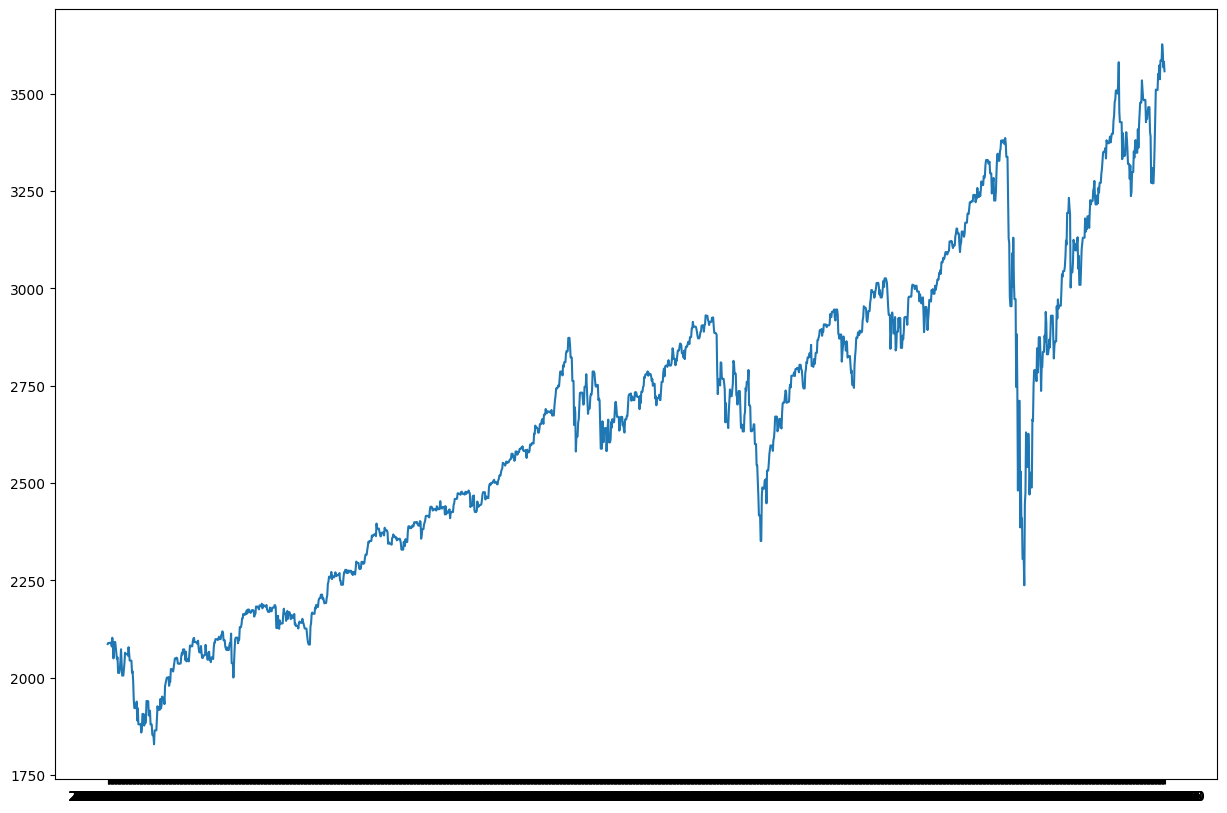

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(sp_df["Date"], sp_df["Close"])
plt.show()

From the above graph we can see it is seasonal and hence we should SARIMA.

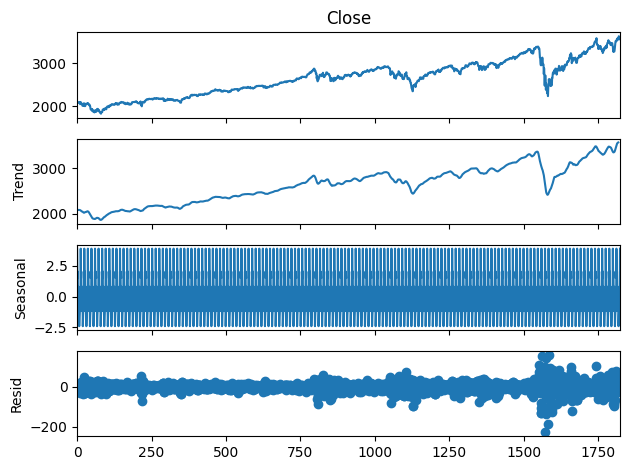

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(sp_df['Close'], model='additive', period=12)
result.plot()
plt.show()

From the above graph we can check that it is yearly seasonality captured daily.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

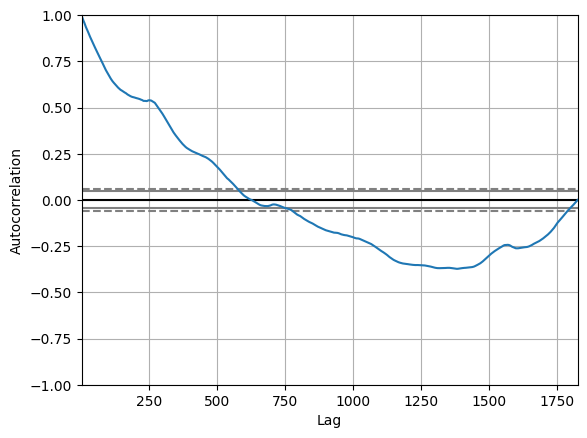

In [ ]:
pd.plotting.autocorrelation_plot(sp_df["Close"])

p value is the used to indicate how many lagged values of the time series are used as predictors.

We can find the value of p by taking the autocorrelation of the Close column.
The plot above shows that the first major change comes around 250 but considering p value as 250 will be very expensive and it is throwing error for creating lags overlapping with the seasonal components. Hence we need to start small with 5 and then 10.

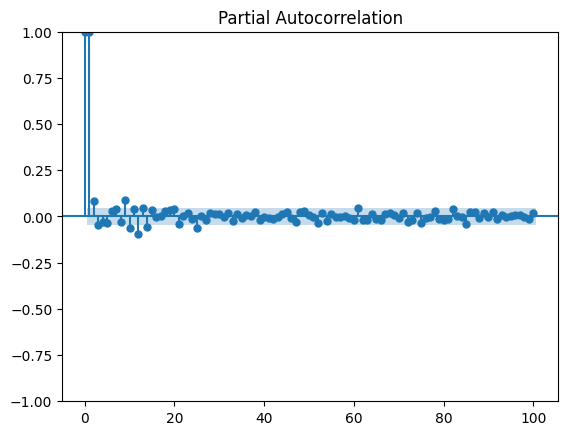

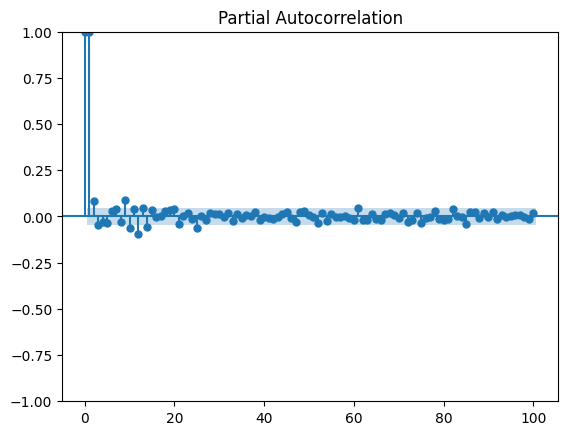

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(sp_df["Close"], lags = 100)

q indicates the size of the moving average window.
We can take the q value by plotting the partial autocorrelation of the Close cloumn. We can see that the starting 2 points are away from rest of the other points hence we take q = 2.

The value for d is either 0 or 1 depending on if the data is stationary or not and here the data is seasonal, hence we take d = 1. d can also be more than 1 since it is the number of times raw observations are differenced to make data stationary

In [ ]:
#Creating a 60 day lag feature
sp_df['lag_60'] = sp_df['Close'].shift(60)

In [ ]:
#Creating rolling stats
sp_df['roll60_min'] = sp_df['Close'].rolling(window=60).min()
sp_df['roll60_mean'] = sp_df['Close'].rolling(window=60).mean()
sp_df['roll60_max'] = sp_df['Close'].rolling(window=60).max()
sp_df['roll60_std'] = sp_df['Close'].rolling(window=60).std()

In [ ]:
sp_df = sp_df.dropna()

In [ ]:
#Split the data in train and test
split_point = int(len(sp_df) * 0.9)
train = sp_df.iloc[:split_point]
test = sp_df.iloc[split_point:]

We are considering yearly seasonality hence we have taken s (seasonal componenet) = 12. We are using the rolling features and 3 day window as exogeneous variables to provide external information that might influence the time series analysis.


In [ ]:
#Fit the model
p, d, q = 5, 1, 2
start_time = time.time()
model=sm.tsa.statespace.SARIMAX(train['Close'],
                exog=train[['lag_60', 'roll60_min', 'roll60_mean', 'roll60_max', 'roll60_std']],
                order=(p, d, q),
                seasonal_order=(p, d, q, 12))

results = model.fit()
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

Training Time: 344.54 seconds


In [ ]:
#Make predictions
start_time = time.time()
predictions = results.forecast(steps=len(test), exog=test[['lag_60', 'roll60_min', 'roll60_mean', 'roll60_max', 'roll60_std']])
end_time = time.time()
print(f"Inference Time: {end_time - start_time:.2f} seconds")

Inference Time: 0.07 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
#Evaluation of the model using RMSE score
rmse = np.sqrt(mean_squared_error(test['Close'], predictions))
print(f'SARIMA RMSE: {rmse}')

SARIMA RMSE: 114.50932045426805


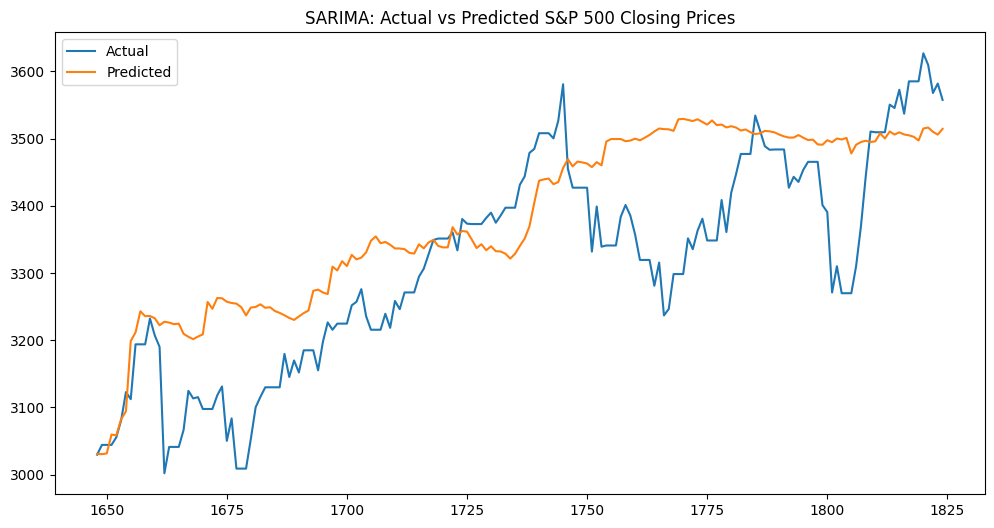

In [ ]:
#Visualizing the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title('SARIMA: Actual vs Predicted S&P 500 Closing Prices')
plt.legend()
plt.show()

In [ ]:
def sarima_objective(trial):
    # Define the hyperparameter search space
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)
    P = trial.suggest_int('P', 0, 3)
    D = trial.suggest_int('D', 0, 2)
    Q = trial.suggest_int('Q', 0, 3)
    s = trial.suggest_categorical('s', [12])

    try:
        # Fit the SARIMA model
        model = sm.tsa.statespace.SARIMAX(train['Close'],exog=train[['lag_60', 'roll60_min', 'roll60_mean', 'roll60_max', 'roll60_std']], order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)

        # Generate predictions
        preds = model_fit.predict(start=len(train), end=len(train) + len(test) - 1,
                                  exog=test[['lag_60', 'roll60_min', 'roll60_mean', 'roll60_max', 'roll60_std']],
                                  dynamic=False)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test['Close'], preds))
        return rmse

    except Exception as e:
        # Return a high RMSE for invalid configurations
        return float('inf')


In [ ]:
# Creating the study and optimizing
start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(sarima_objective, n_trials=20)
end_time = time.time()
# Displaying the best hyperparameters and corresponding RMSE
print("Best Hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)
print(f"Optimization Time: {end_time - start_time:.2f} seconds")

[I 2024-12-04 17:51:58,683] A new study created in memory with name: no-name-d72ea02b-aa63-46ae-a3e1-4464ffac1326
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No suppor

Best Hyperparameters: {'p': 4, 'd': 1, 'q': 3, 'P': 3, 'D': 0, 'Q': 2, 's': 12}
Best RMSE: 97.68251537007104
Optimization Time: 1384.79 seconds


In [ ]:
# Refitting the model with best parameters
best_params = study.best_params
best_model = sm.tsa.statespace.SARIMAX(train['Close'],
                                      exog=train[['lag_60', 'roll60_min', 'roll60_mean', 'roll60_max', 'roll60_std']],
                                      order=(best_params['p'], best_params['d'], best_params['q']),
                                      seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
start_time = time.time()
best_model_fit = best_model.fit(disp=False)
end_time = time.time()
print(f"Training Best Param Time: {end_time - start_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training Best Param Time: 80.07 seconds


In [ ]:
start_time = time.time()
preds = best_model_fit.predict(start=len(train), end=len(train) + len(test) - 1,
                                      exog=test[['lag_60', 'roll60_min', 'roll60_mean', 'roll60_max', 'roll60_std']],
                                      dynamic=False)
end_time = time.time()
print(f"Inference Best Param Time: {end_time - start_time:.2f} seconds")
# Calculate RMSE for the best model
best_rmse = np.sqrt(mean_squared_error(test['Close'], preds))
print("RMSE of the best model on the test set:", best_rmse)

Inference Best Param Time: 0.04 seconds
RMSE of the best model on the test set: 97.68251537007104


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


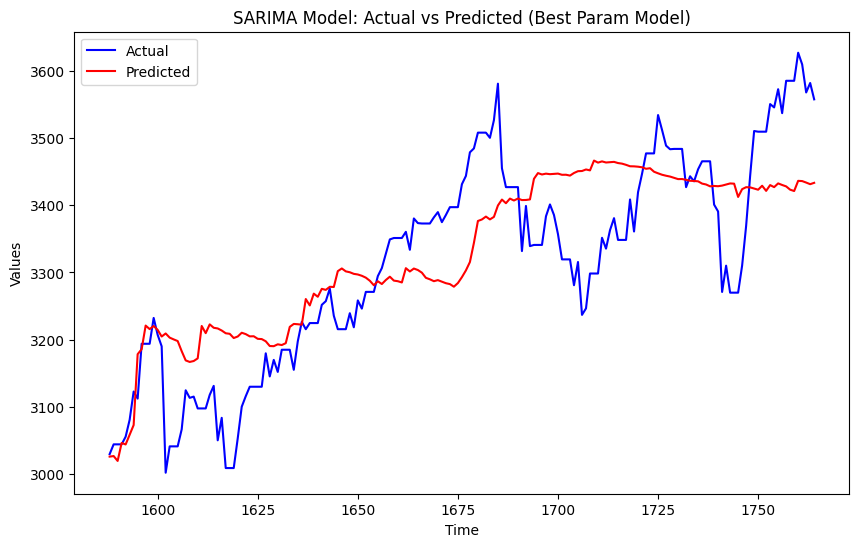

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(train), len(train) + len(test)), test['Close'], label="Actual", color="blue")
plt.plot(range(len(train), len(train) + len(test)), preds, label="Predicted", color="red")
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("SARIMA Model: Actual vs Predicted (Best Param Model)")
plt.legend()
plt.show()